    
| Author      | Date        | Vaccancy | Reading time |
| ----------- | ----------- | ---- | ---- |
| Michael Feil      | July 16th 2021       | Federated Learning in Healthcare, TU Munich | 20min |


## Table of Contents:
* [**Part 1**: Create non-iid client distributions](#ref1)
* [**Part 2**. Apply gradient descent for one client](#ref2)
* [2.1: Right on track: gradient descent ftw!](#ref2.1)
* [2.2: Taking the detour: an intro to gradient descent in python](#ref2.2)
* [2.3: Gradient descent for both clients and the global distribution](#ref2.3)
* [**Part 3**: FedAvg with non-iid client data](#ref3)
* [3.1: Taking the detour: An programming intro to FedAvg](#ref3.1)
* [3.2: Back on track: Federated Averaging](#ref3.2)
* [3.3: How to mess with Federated Averaging](#ref3.3)
* [**Part 4**: Our salvation: Posterior Averaging?](#ref4)
* [**Part 5**: Summary](#ref5)
* [**Part 6**: References](#ref6)

Hint: For Interactivity, better open this Blog Post on Binder.org. [Simply press on this logo: ![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/michaelfeil/fl-in-healtcare-viz/HEAD?filepath=colab-viz-fedavg-vs-gd.ipynb)

## **Part 0**: Introduction
Think about the following scenario: 

You have personal images on your smartphone. So do your friends. (of course they do, we live in 2021!) As a Machine Learning engineer your goal is to create a machine learning model, which does a good job at the classification of your images from your phone and automatically clusters them in various folders, e.g. "cats" and "beergarden munich". You also plan to help some of your friends sorting their images. 

In the past (or better say before 2017), your proposal was, that everyone of your friend uploads their images to your of server. Then all of images get aggregated, and you train and test a ML model. There was just one drawback: None of our friends wanted to share their sensitive image data? - Now you have the answer: **Federated Learning (FL)**!

The introduction of **Federated Averaging (FedAvg)** by McMahan et al.[[2](#z2)] in 2017 enables us now, to train a model without uploading any images to any kind of central server. Isn't that great!?! Let's look at the images below.

<figure>
    <center>
    <a class="anchor" id="Figure1"></a>
    <img src="./blog_imgs/peter_kairouz_advances_in_FL.png" alt='missing image' width="600"/>
    <a href=#z3>
        <figcaption> Figure1 © Image adapted from Peter Kairouz [3] </figcaption>
    </a>
    </center>
</figure> 




As in the [Figure1](#Figure1) above, in the case of ***cross-device*** FL with FedAvg, our cloud-based central server will send an inital state of the model parameters to thousands of mobile devices at once. The clients then update their version of the model parameters using **stochastic gradient descent (SGD)**. The updated model parameters get communicated back to the server, where the client parameters get aggregated using weighted averaging. The process then starts again with the slightly improved parameters of our model. 

### Executive Summary
In the following sections, we will discuss a suitable heterogenous data distribution for the clients [Part 1](#ref1), code and visualize gradient descent and derive the global posterior in [Part 2](#ref2). In [Part 3](#ref3), we will find some unexpected hickups using FedAvg[[2](#z2)] and solve them by introducing a FedPA[[1](#z1)] in [Part 4](#ref4). 

In [1]:
# import some utilities
from computation_fedavg_gd import grad_descent, partial_derivative
from computation_fedavg_gd import MultivarianteGaussian
from computation_fedavg_gd import PDFsManipulate

# import the usual suspects (excluding pandas as pd)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## **Part 1**: Create non-iid client distributions <a class="anchor" id="ref1"></a>
### Multivariante Gaussians: Draw the client distributions over our model weights / over theta 



First step: lets pick two client distributions. The distributions symbolize the weights of the models on the phones, which we try to optimize. 
For this notebook, we plot with the following simplifications: assume your model has 2 tunable weights theta, and there are 2 clients. The theta over our target function J has a Gaussian distribution.

Further reading: The Multivariante Gaussian is defined in ```
computation_fedavg_gd.py```. 

```python
MultivarianteGaussian??
```

In [2]:

mu1, sigma1 = np.array([0, 1]), np.array([[1.0, -0.9], [-0.5, 1.5]])
mu2, sigma2 = np.array([0, -1.2]), np.array([[1.5, 0.6], [0.9, 1.0]])
multivariante1 = MultivarianteGaussian(
    mu=mu1, sigma=sigma1
)
multivariante2 = MultivarianteGaussian(
    mu=mu2, sigma=sigma2
)
MultivarianteGaussian??

In [3]:
# calculate at our target function over a sampling grid
from plot_fedavg_gd import SAMPLE_GRID_VECTOR
J1 = multivariante1.evaluate(theta_vec=SAMPLE_GRID_VECTOR)
J2 = multivariante2.evaluate(theta_vec=SAMPLE_GRID_VECTOR)
print(f"evaluated gaussian over a 2D sampling grid {SAMPLE_GRID_VECTOR.shape} for a third target vector {J1.shape}")

evaluated gaussian over a 2D sampling grid (71, 71, 2) for a third target vector (71, 71)


alright, lets make some fancy visualizations of our client 1 distribution

<IPython.core.display.Javascript object>


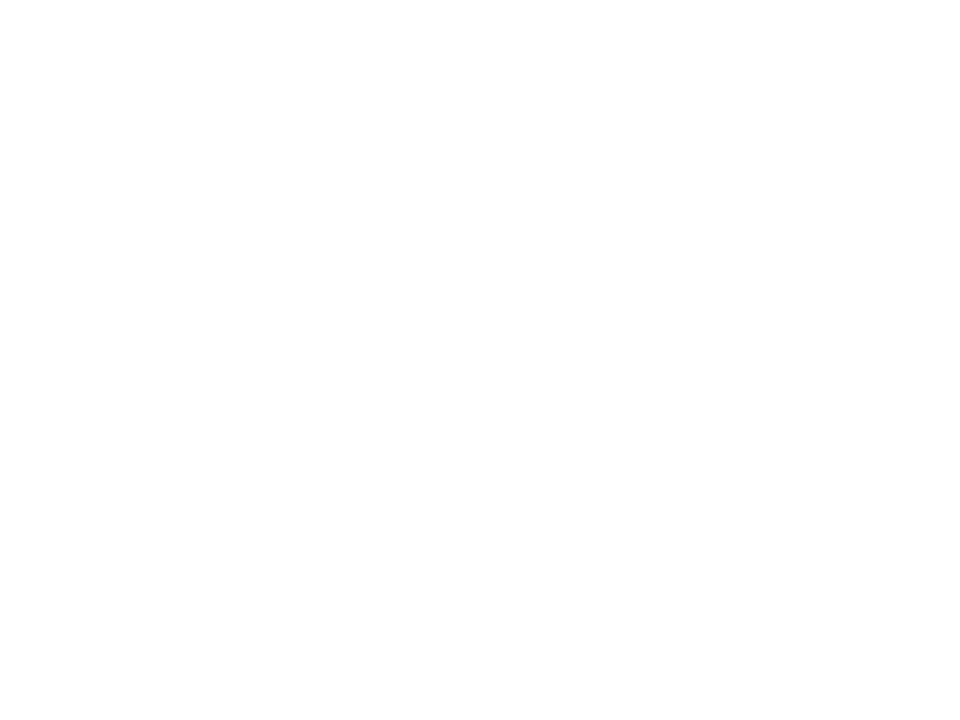

<IPython.core.display.Javascript object>


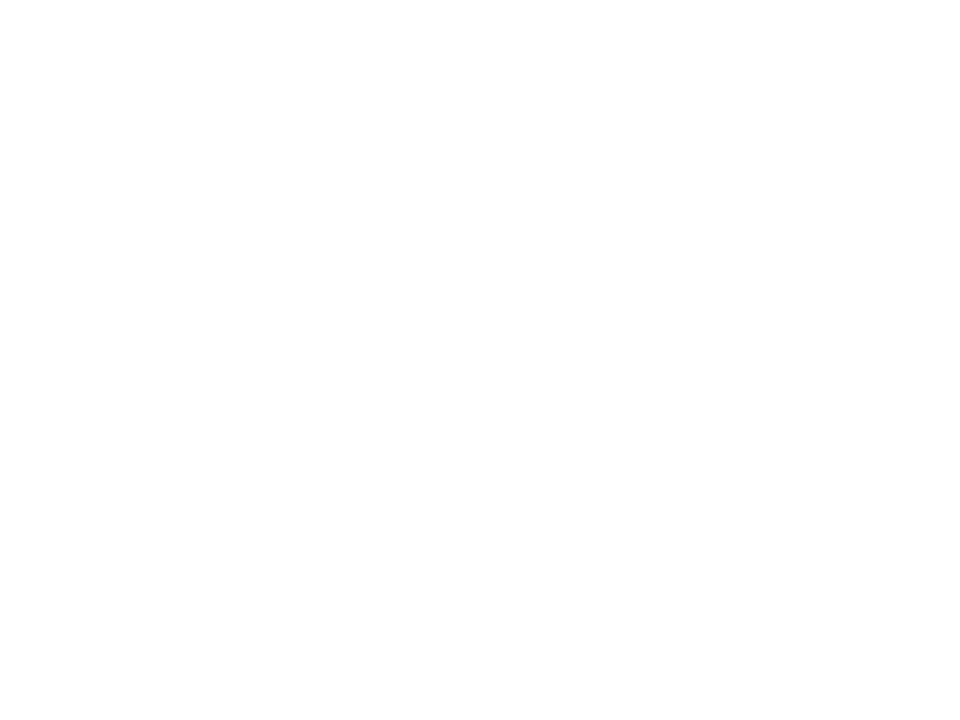

In [4]:
%matplotlib notebook 
# lets visualize our distributions

def client_function_draw(eval_sample, cmap = matplotlib.cm.Greens):
    # adjust some 3D settings
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.view_init(elev=20.0, azim=-125)
    ax.dist = 7.5
    ax.set_zticks(np.linspace(0, 0.2, 5))
    # labels
    ax.set_xlabel(r"${\theta}_0$")
    ax.set_ylabel(r"${\theta}_1$")
    ax.set_zlabel(r"J(${\theta}_0$, ${\theta}_1$)")

    # plot a 3D curve
    ax.plot_wireframe(
        SAMPLE_GRID_VECTOR[:,:,0],
        SAMPLE_GRID_VECTOR[:,:,1],
        eval_sample,
        rstride=3,
        cstride=3,
        linewidth=0.5,
        antialiased=True,
        cmap=matplotlib.cm.Greens,
        zorder=1,
    )
    # make a 2D Countour plot in green on the bottom
    ax.contourf(
        SAMPLE_GRID_VECTOR[:,:,0],
        SAMPLE_GRID_VECTOR[:,:,1],
        eval_sample,
        zdir="z",
        offset=-np.max(eval_sample)/20,
        cmap=cmap,
        zorder=0,
    )
    return ax

fig = client_function_draw(J1)
fig = client_function_draw(J2, cmap="Oranges")

# **Part 2**. Apply gradient descent for one client <a class="anchor" id="ref2"></a>
Second step: Awesome, we have the parameter spaces for our two image recognition models. Let's do some training, every client simply by himself, with its own local data. If you don't know how gradient descent works, a [quick detour to 2.2.](#ref2.2) might help! :)

## 2.1 Right on track: gradient descent ftw! <a class="anchor" id="ref2.1"></a>
Let's see how this would look like, with Gradient Descent applied. 

In [5]:
# lets start with some random values for theta. come back later, and tune them, if you like.
THETA = np.array([-2.0, 0.1])

iter: 0, theta: [-1.9, gradient: 3.313123563351253e-05
iter: 50, theta: [-1.6, gradient: 0.00018967341849882979
iter: 100, theta: [-0.9, gradient: 0.0025225717318137636
iter: 150, theta: [-0.2, gradient: 0.00034660933191360543
iter: 200, theta: [-0.0, gradient: 1.3755523300240657e-05
iter: 250, theta: [-0.0, gradient: 3.125739587883647e-06
iter: 300, theta: [-0.0, gradient: 8.610496716188187e-07
iter: 350, theta: [-0.0, gradient: 2.3839203919240326e-07
stop condition reached after 384 iterations


<IPython.core.display.Javascript object>


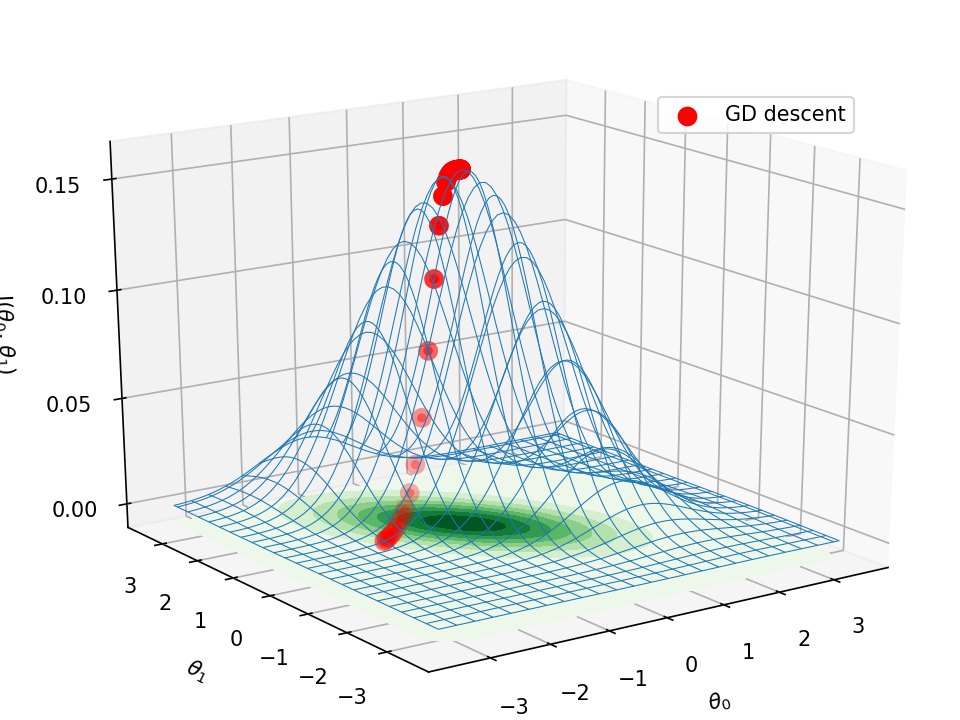

In [6]:
%matplotlib notebook 

# apply gradient descent
history = grad_descent(
    function_descent=multivariante1.evaluate,
    theta=THETA,
    eps=1e-07,  # stop condition
    nb_max_iter=1000,  # max iterations,
    verbose=1,
)
ax = client_function_draw(J1)

ax.scatter(
    history[:, 0][::10],
    history[:, 1][::10],
    history[:, 2][::10],
    label="GD descent",
    c="red",
    lw=5,
    zorder=100,
)
fig = ax.legend()

Awesome.
If you are interested how gradient descent works, check out the file ```computation_fedavg_gd.py``` in this repository by taking the detour below.
In the next field, we also visualize the second function, which gives an overview over our non-iid setting.

**client 1**
create 3D plot using SGD on [('GD client 1', 'green')]over distribution ['client 1 target']


<IPython.core.display.Javascript object>


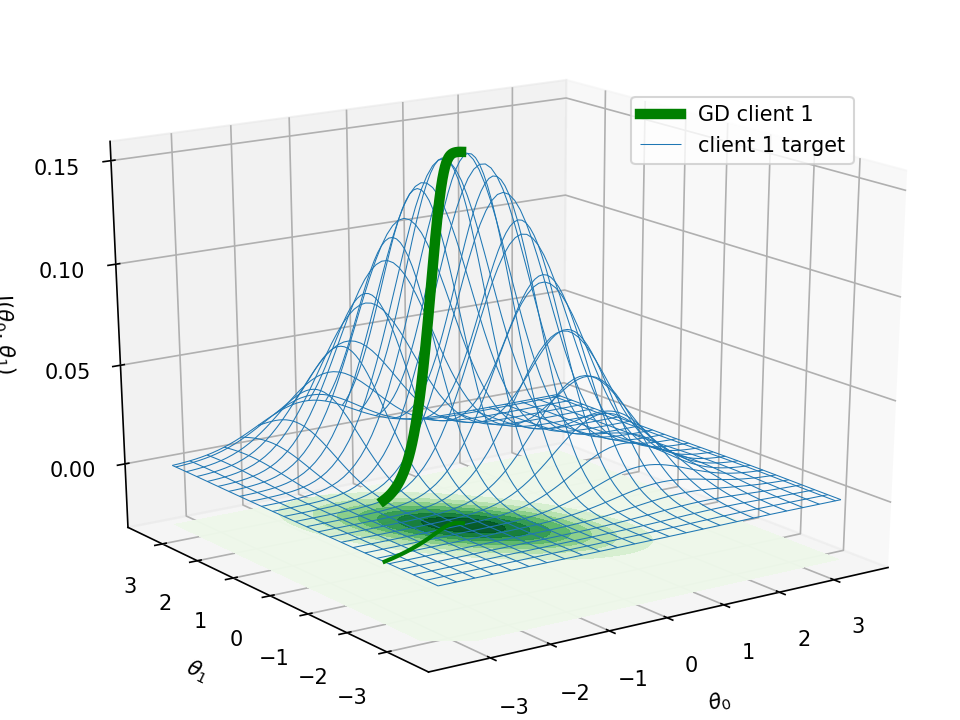

**client 2**
create 3D plot using SGD on [('GD client 2', 'orange')]over distribution ['client 2 target']


<IPython.core.display.Javascript object>


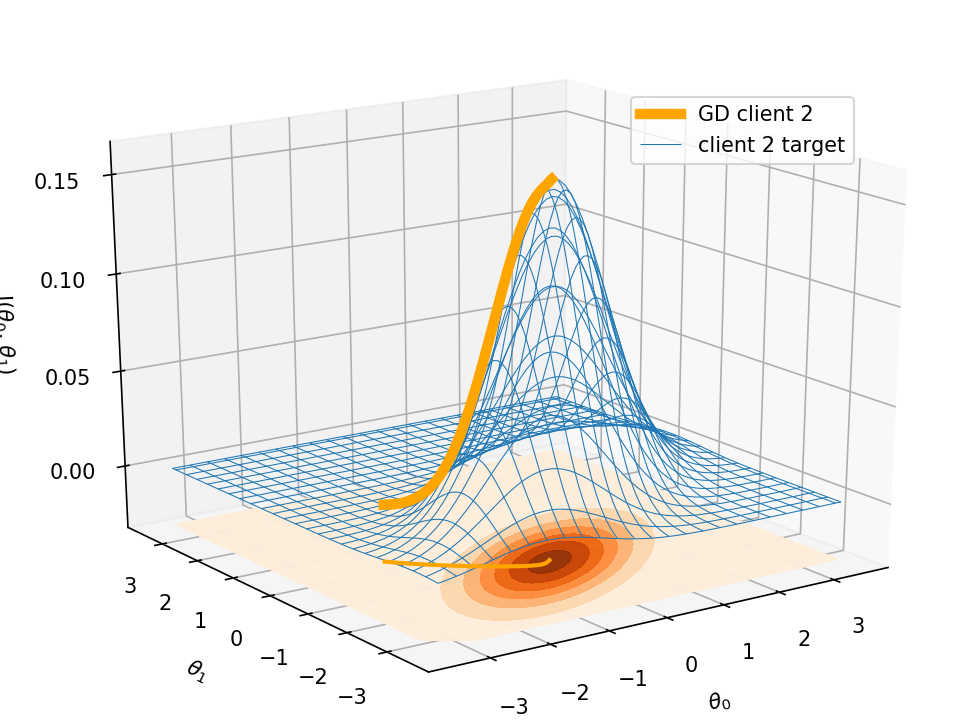

In [7]:
from plot_fedavg_gd import mpl_multivariante_3d_gd
print("**client 1**")
fig = mpl_multivariante_3d_gd(
    name_labels=[ "GD client 1"],
    colors=[ "green"],
    functions=[ multivariante1.evaluate],
    target_function=[J1],
    cmap_target=[ "Greens"],
    label_target=[ "client 1 target"],
    theta=THETA,
)
print("**client 2**")
fig = mpl_multivariante_3d_gd(
    name_labels=["GD client 2", ],
    colors=["orange", ],
    functions=[multivariante2.evaluate, ],
    target_function=[J2],
    cmap_target=["Oranges"],
    label_target=["client 2 target", ],
    theta=THETA,
)

## 2.2  Taking the detour: an intro to gradient descent in python<a class="anchor" id="ref2.2"></a>

If you are not in ahurry, below, you can see how gradient descent is implemented. 

1. We optimize one paramter at a time. (line-search) 

   - for all $\theta_i$ in vector $\theta$ do: $$  \theta_{i, new} \leftarrow \theta_{i}- \alpha_{lr} \nabla \theta_{i}  $$
   
2. GD: linea-search for n iterations over one function

In [8]:
print("# Usage of line-search: optimize one parameter at a time")
partial_derivative??

# Usage of line-search: optimize one parameter at a time


In [9]:
print("# Evaluating gradient descent for one function:")
grad_descent??

# Evaluating gradient descent for one function:


## **2.3**: Deriving the global posterior distribution <a class="anchor" id="ref2.3"></a>

Lets add two functions client1 + client2 together! This way, we do like if we would aggregate our clients images, and could train a central model without Federated Learning.

We assume to have a **quadratic loss** function, and that there is no prior for each of our clients. That way, our global posterior distribution decomposes into a multiplication of local posteriors.
This means for our client data $i$, that we can compute the global posterior in our case. 
$$\mathbb{P}_{global}(\boldsymbol{\theta} \mid D) \propto \prod_{i=1}^{N} \mathbb{P}\left(\boldsymbol{\theta} \mid D_{i}\right)$$

Since we assumed to have two Gaussian distrbutions on our clients, we can look up in the Matrix Cookbook [[5](#z5)] on how to calculate the Posterior as a product of gaussians:

__Posterior: Product of gaussian densities__:

Let $\mathcal{N}_{\mathbf{x}}(\mathbf{\mu}, \mathbf{\Sigma})$ denote a density of $\mathbf{x}$, then
$$
\begin{aligned}
c_{c} \mathcal{N}_{\mathbf{x, global}}\left(\mathbf{\mu}_{c}, \mathbf{\Sigma}_{c}\right) =
\mathcal{N}_{\mathbf{x, client1}}\left(\mathbf{\mu}_{1}, \mathbf{\Sigma}_{1}\right) \cdot \mathcal{N}_{\mathbf{x, client2}}\left(\mathbf{\mu}_{2}, \mathbf{\Sigma}_{2}\right)
\\
\end{aligned}
$$

Awesome, the product is again a Gaussian. All we need to do is compute the normalization constant $c_{c}$ , plus our  $ \mathbf{\mu}_{c}$ and $ \mathbf{\Sigma}_{c}  $ of the new distribution

$$
\begin{aligned}
\mathbf{\mu}_{c}=&\left(\boldsymbol{\Sigma}_{1}^{-1}+\boldsymbol{\Sigma}_{2}^{-1}\right)^{-1}\left(\boldsymbol{\Sigma}_{1}^{-1} \mathbf{\mu}_{1}+\boldsymbol{\Sigma}_{2}^{-1} \mathbf{\mu}_{2}\right) \\
\boldsymbol{\Sigma}_{c}=&\left({\boldsymbol{\Sigma}}_{1}^{-1}+{\boldsymbol{\Sigma}}_{2}^{-1}\right)^{-1}
\end{aligned}
$$

The normalization constant can be calculated using:

$$
\begin{aligned}
c_{c}=\mathcal{N}_{x = \mathbf{\mu}_{1}}\left(\mathbf{\mu}_{2},\left(\boldsymbol{\Sigma}_{1}+\boldsymbol{\Sigma}_{2}\right)\right) \\
\quad=& \frac{1}{\sqrt{\operatorname{det}\left(2 \pi\left(\boldsymbol{\Sigma}_{1}+\mathbf{\Sigma}_{2}\right)\right)}} \exp \left[-\frac{1}{2}\left(\mathbf{\mu}_{1}-\mathbf{\mu}_{2}\right)^{T}\left(\boldsymbol{\Sigma}_{1}+\boldsymbol{\Sigma}_{2}\right)^{-1}\left(\mathbf{\mu}_{1}-\mathbf{\mu}_{2}\right)\right] \\
\end{aligned}
$$

__Numeric calculation: Posterior__ :

But we could also do it numerically, by just calculating:
$$\mathbb{P}_{global} = \frac{(multivariante1.evaluate * multivariante2.evaluate)} {c_{normalize}} $$


In [10]:
# Numeric calculation

# basically doesis (multivariante1 + multivariante2) / norm
f_posterior_num = PDFsManipulate(functions=[multivariante1.evaluate, multivariante2.evaluate], method = np.multiply)

# evaluate on SAMPLE_GRID
J = f_posterior_num.evaluate(theta_vec = SAMPLE_GRID_VECTOR)

In [11]:
# Exact calculation
inv_sigma1 = np.linalg.inv(sigma1)
inv_sigma2 = np.linalg.inv(sigma2)
sum_inv = np.linalg.inv((inv_sigma1+inv_sigma2))
sigma_global_posterior = sum_inv
mu_global_posterior = sum_inv @  (inv_sigma1 @ mu1 + inv_sigma2 @ mu2)

# using the math above
f_posterior_exact = MultivarianteGaussian(
    mu=mu_global_posterior, 
    sigma=sigma_global_posterior
) 
# evaluate on SAMPLE_GRID
J_exact = f_posterior_exact.evaluate(theta_vec = SAMPLE_GRID_VECTOR)





argmax J_exact (array([33], dtype=int64), array([42], dtype=int64))
argmax J_num (array([32], dtype=int64), array([41], dtype=int64))


<IPython.core.display.Javascript object>


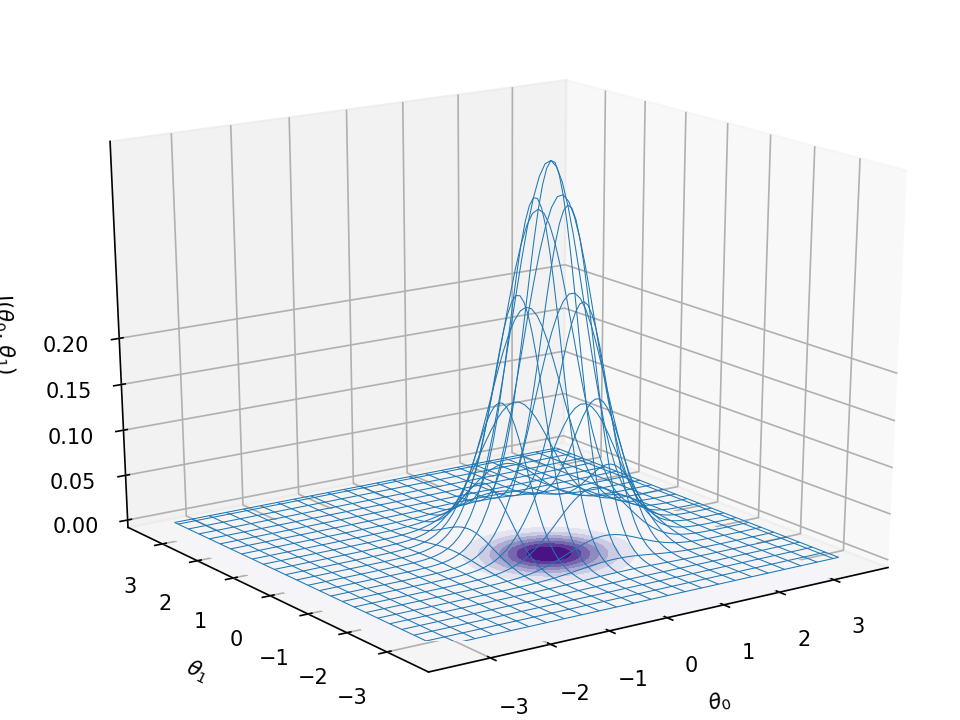

In [12]:
print("argmax J_exact", np.where(J_exact==J_exact.max()))
print("argmax J_num", np.where(J==J.max()))
ax = client_function_draw(J_exact, cmap="Purples")

By having the sigma and mu, we can reconstruct the global posterior, finding the same argmax as with the numerical calculations.

Once we have the posterior, we can run even GD on it, or directly go to the argmax at $\mu$ of the f_posterior_exact:

create 3D plot using SGD on [('GD on global posterior', 'purple'), ('GD client 2', 'orange'), ('GD client 1', 'green')]over distribution ['client 1 target', 'client 2 target', 'global posterior']


<IPython.core.display.Javascript object>


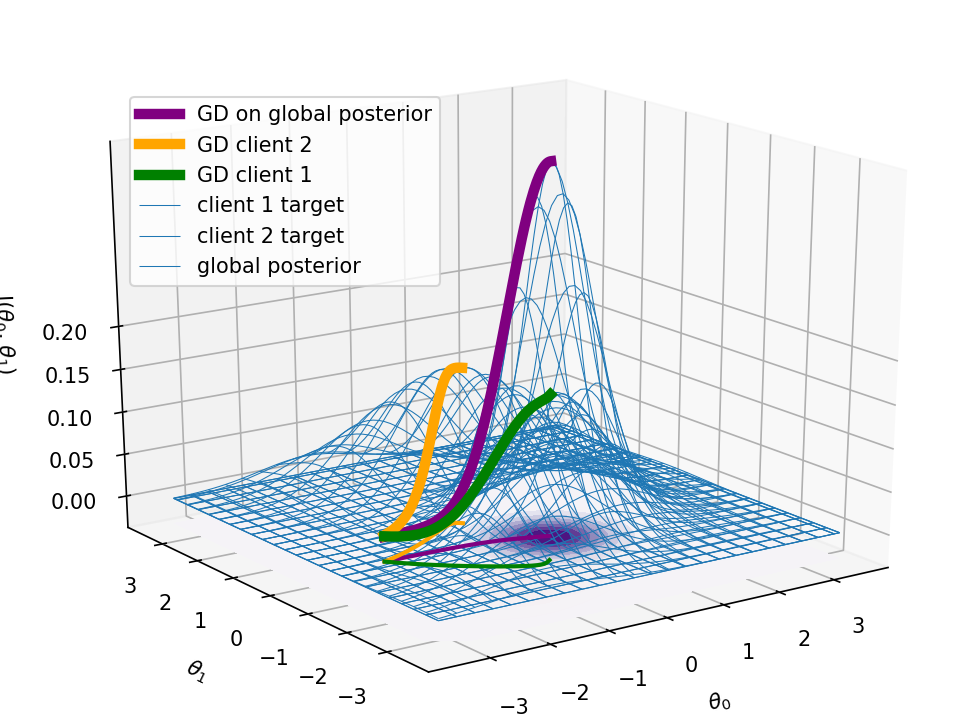

In [13]:
#lets do, as if we could aggregate our global function
fig = mpl_multivariante_3d_gd(
        name_labels=["GD on global posterior", "GD client 2", "GD client 1"],
        colors=["purple", "orange", "green"],
        functions=[f_posterior_exact.evaluate, multivariante1.evaluate, multivariante2.evaluate],
        target_function=[ J1, J2, J_exact],
        cmap_target=[ "Greens", "Oranges", "Purples"],
        label_target=[ "client 1 target", "client 2 target", "global posterior"],
        theta=THETA,
    )

# **Part 3**: FedAvg with non-iid client data<a class="anchor" id="ref3"></a>


## 3.1 Taking the detour: A programming intro to FedAvg <a class="anchor" id="ref3.1"></a>
FedAvg basically works like this algorithm below. We initialize some theta on the server, and send it to our two clients. Each client does then a short time of training by using gradient decent. Then we send back our theta from each of the clients and average the results on the server. Voila! We improved our theta model weights a bit. This is called one **communication round**. If we do it repeatatly, we hopefully get to a good model in the end. 
```python 
theta = [theta0, theta1]
nb_rounds = 10
gd_steps_local = 20


def client_update(theta):
    """on the clients"""
    
    client_data = client.get_distribution() # get the client data
    
    # update the parameters
    for i in range(gd_steps_local):
        theta = grad_descent(client_data, theta, nb_steps=1)
    
    # send back the most recent model
    return theta
    
def fedavg_server_update(theta_0):
    """on the server"""
    theta_current = theta_0
    
    for i in range(nb_rounds):
        # in parallel
        theta_client1 = client1.client_update(theta_current)
        theta_client2 = client2.client_update(theta_current)  
        
        theta_current = average(theta_client1, theta_client2)
    
    # output best model at the end of training
    return theta_current 
```


In [14]:
# optional, get the source code 
from computation_fedavg_gd import fedavg
fedavg??

## 3.2 Back on track: Federated Averaging <a class="anchor" id="ref3.2"></a>
Remember our example in the beginning? We had the idea of doing the training local on the clients hardware, right where the client images live. We are going to simulate this with the function below!

<IPython.core.display.Javascript object>


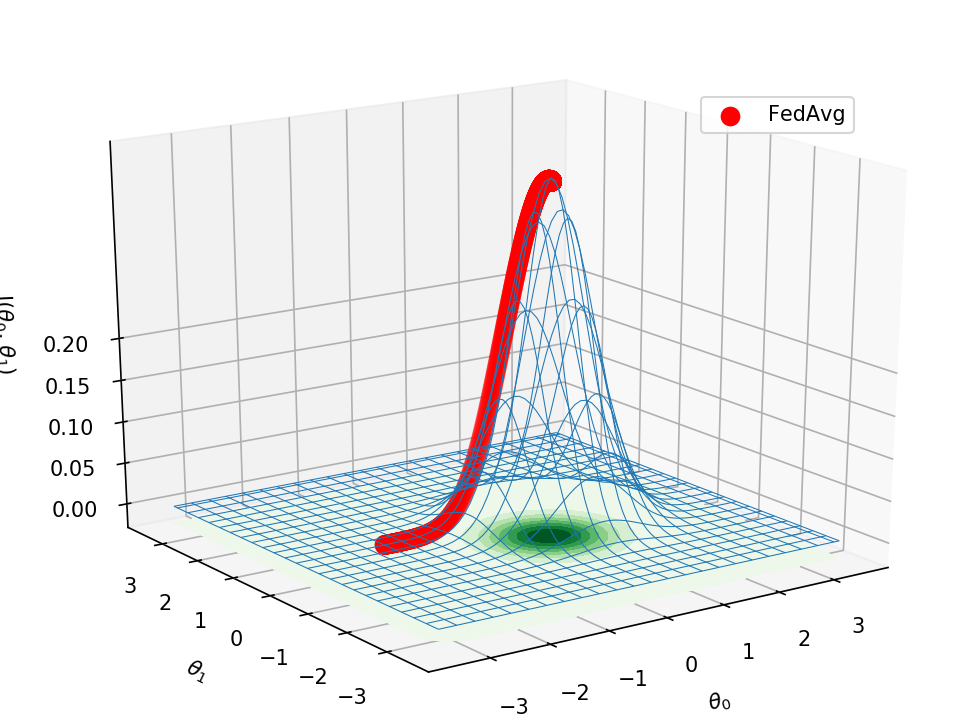

ϴ_final:   [ 0.64033788 -0.31200206] 
ϴ_optimum: [ 0.67346939 -0.2433281 ]


In [15]:
from computation_fedavg_gd import fedavg as fedavg_server_update

server_history , _  = fedavg_server_update(
    function_clients=[multivariante1.evaluate, multivariante2.evaluate],  # clients
    function_eval=f_posterior_exact.evaluate,   
    communication_rounds = 1000,
    gd_steps_local = 1,
    theta=THETA,
)

ax = client_function_draw(J_exact) # draw global function 

ax.scatter(
    server_history[:, 0],
    server_history[:, 1],
    server_history[:, 2],
    label="FedAvg",
    c="red",
    lw=5,
    zorder=100,
)
ax.legend()
print("\u03F4_final:  ",server_history[-1,:-1], "\n\u03F4_optimum:", mu_global_posterior)

__Congratiulations! You made it. FedAvg reaches the global optimum.__
Through iterativly averiging our client updates, we trained one global model, which can now classify the client1 and client2 data optimally. Despite it is not the posterior modes (maximum) of any of the local distributions, we still found the best solution according to our a global cost function. 
__But.. is that really always true?__ Can FedAvg always find the optimum of the global cost function?

## 3.3 How to mess with Federated Averaging <a class="anchor" id="ref3.3"></a>
So far, FedAvg has been really successfull. But remember how our client distributions have an **heterogenous distribution** (non-i.i.d.)?

Below, we will see, that FedAvg is not guaranteed to converge to the global optimum, even if our problem is nearly convex towards the top and a very minimal implementation of GD finds the optimum. This happens, if we would like to improve our **communication efficiency** by increasing our step size and thus communicating the models between client an server less often. 

```python
communication_rounds = 20
gd_steps_local = 120
```

In the code below, observe how we fail to find the optimal solution using FedAvg. 

<IPython.core.display.Javascript object>


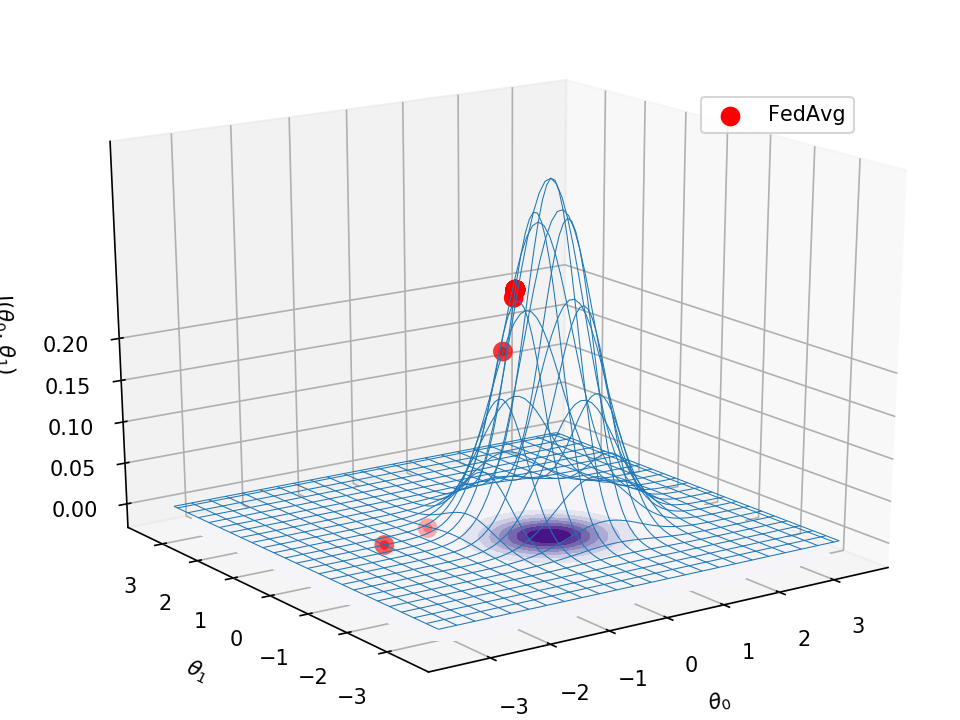

ϴ_final:   [ 0.14657315 -0.12253487] 
ϴ_optimum: [ 0.67346939 -0.2433281 ]


In [16]:
server_history , _  = fedavg_server_update(
    function_clients=[multivariante1.evaluate, multivariante2.evaluate], # clients
    function_eval=f_posterior_exact.evaluate,    
    communication_rounds = 20,
    gd_steps_local = 120,
    theta=THETA,
)

ax = client_function_draw(J_exact, cmap="Purples") # plot global function

ax.scatter(
    server_history[:, 0],
    server_history[:, 1],
    server_history[:, 2],
    label="FedAvg",
    c="red",
    lw=5,
    zorder=100,
)
fig = ax.legend()
print("\u03F4_final:  ",server_history[-1,:-1], "\n\u03F4_optimum:", mu_global_posterior)

### Explainations:
FedAvg does not find the optimal solution anymore. Instead of optimizing for the global posterior mode (the function you see in Purple above), we just average the local posterior modes. So in the end, we find a theta value, which drifts towards the client posterior modes. In i.i.d. scenarios, this wasn't a problem. Practically speaking, if you and your friends are all taking the same pictures, FedAvg is more likley to find an optimal solution for your model, compared to if you are taking pictures from different motives in different regions. 


# 4. Our salvation: Posterior Averaging? <a class="anchor" id="ref4"></a>

One thing we have not considerded at all, is the covariance of the Posterior of each client. If we could estimate more than just the argmax (mu) of our client posterior (i.e. using gradient descent), we could do better. Lets estimate also the Sigma matrix also, and see what we can do.


compared to the pseudo code above for FedAvg the server code will remain almost the same.
```python
class PA_server:
    ...
```

On the client we will change a bit of code. Most crucially, we wil try to infer both, the Sigma and mu to average the posteriors on the server. In practive we would not be able to communicate a Matrix of the size of Sigma. 
1. with markov_chain_monte_carlo do some gradient descent steps and draw l samples 
2. using the samples, find the best sigma and mu for the samples from theta
3. compute a update delta from sigma, sigma_estim and initial model value.

Especially with the help of the last step

```python
class PA_client:
    ...
    def train(self, theta_0):
        samples_theta = markov_chain_monte_carlo ( theta_0 )
        sigma_estim, mu_estim = estimate_best(samples_theta)
        return delta = np.linalg.solve(sigma_estim, theta_0 - mu_estim)
```



In [31]:
# Disclaimer. This code is not actually meant to perform the same calculations as FedPa. 
# It just shows, that once a sigma and mu is estimated, a better result than FedAvg can be achieved.

class PA_client:
    """A noisy client mimicking estimating the posterior"""
    def __init__(self, multivariante):
        self.mv = multivariante
        
    def train(self, theta_0):
        """update finding the closed-form solution from the estimated sigma_estim, mu_estim
        # goal: send an update which has size of theta_0.shape (n,)
        
        :return: delta, array of shape theta_0.shape (and not sigma.shape (n,n)!!)
        """
        sigma_estim, mu_estim = self._incorrect_mcmc(theta_0)
        delta = np.linalg.solve(sigma_estim, theta_0 - mu_estim)
        
        return delta 
        
    def _incorrect_mcmc(self, theta_0_ignored):
        """
        estimates its client distribution. naive assumption, not actual mcmc!
        doing nothing with theta_0  -> just adding some noise to the true sigma and mu!.
        
        normally would use gd and Markov chain Monte Carlo approximation to find samples,
        and then fit the best gaussian (sigma and mu) to it.
        
        :return: sigma_estim and mu_estim
        """
        sigma_estim = self.mv.sigma + np.random.normal(0, 0.1, self.mv.sigma.shape)
        mu_estim = self.mv.mu + np.random.normal(0, 0.1, self.mv.mu.shape)
        return sigma_estim, mu_estim        
    

class PA_server:
    """Posterior Averaging server. Does the same as FedAvg server"""
    def __init__(self, pa_client1, pa_client2):
        self.pa_client1 = pa_client1
        self.pa_client2 = pa_client2
        
    def train_fedpa(self, theta_0: np.ndarray, lr_alpha: float, communication_rounds: int):
        """run training with 2 clients"""
        theta = theta_0
        history_server = [theta]
        for i in range(communication_rounds):
            # local epochs, client 1
            delta_client1 = self.pa_client1.train(theta)
            # local epochs, client 2
            delta_client2 = self.pa_client2.train(theta)
            # average deltas
            theta = theta - lr_alpha * (delta_client1 + delta_client2) / 2
            history_server.append(theta)
        return np.asarray(history_server)

*Disclaimer2:* As you have seen, many parts of the code have been drastically simplified to fit in this notebook. Most prominently  the mcmc is quite unrealistic, since we cannot directly observe ```mv.sigma```. This might become more clear, when you set e.g. ```theta_0 = np.array([-10000,-10000])```, where the posterior estimation would be infeasible. The original code is available at [[6](#z6)]. 

However the implementation above gives an intuiton about Posterior Averaging, and uses just as many lines of actual python code as we would use in pseduocode.

Lets see, how this performs.

<IPython.core.display.Javascript object>


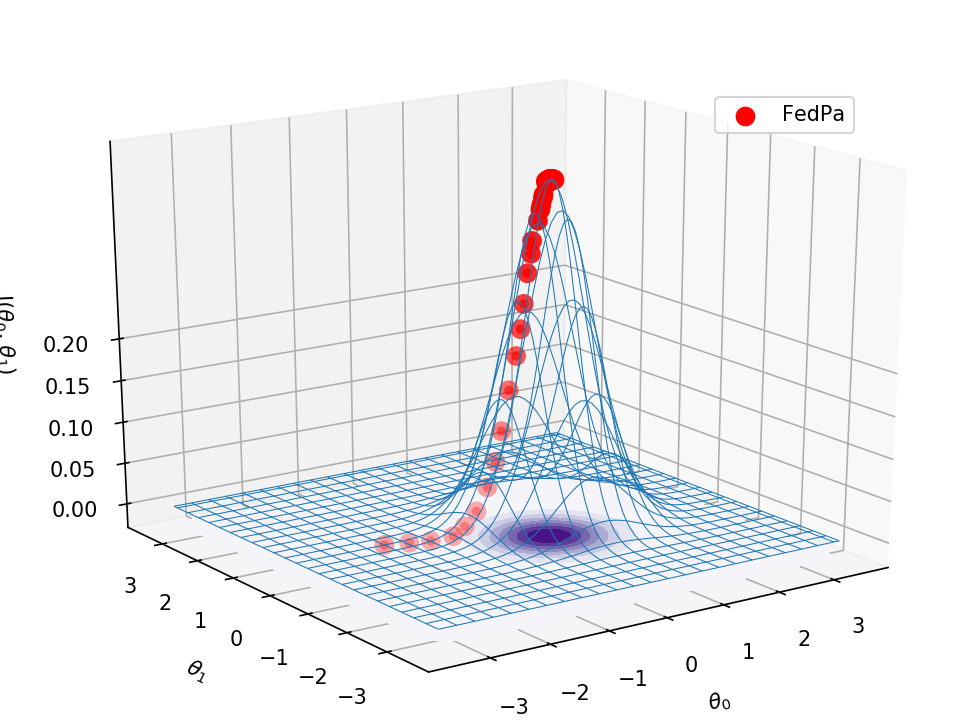

ϴ_final:   [ 0.72708424 -0.25266227] 
ϴ_optimum: [ 0.67346939 -0.2433281 ]


In [29]:
client1 = PA_client(multivariante1)
client2 = PA_client(multivariante2)

server = PA_server(client1, client2)

server_history = server.train_fedpa(theta_0=THETA, lr_alpha=0.1, communication_rounds=50)
accuracies = f_posterior_exact.evaluate(theta_vec = server_history)

ax = client_function_draw(J_exact, cmap="Purples") # plot global function

ax.scatter(
    server_history[:, 0],
    server_history[:, 1],
    accuracies,
    label="FedPa",
    c="red",
    lw=5,
    zorder=100,
)
fig = ax.legend()
print("\u03F4_final:  ", server_history[-1,], "\n\u03F4_optimum:", mu_global_posterior)

Finally, we made it! Our  FedPA "Light" converged to the optimum!

## 4.1 FedPA: Beyond the simplified implementation <a class="anchor" id="ref4.1"></a>

In this chapter, we already used Posterior Averaging to find our optimal $\theta$. As you can see in [Figure2 below](#Figure2), instead of using GD on the clients, we estimated our covariance and our $mu$ of the clients posterior distribution, and then send back the computed $\Delta$ .

<figure>
    <center>
    <a class="anchor" id="Figure2"></a>
    <img src="./blog_imgs/fedavg-and-fedpa-illustration.gif" alt='missing gif' width="600"/>
    <a href=#z4>
        <figcaption> Figure2 © GIF adapted from Maruan Al-Shedivat [4] </figcaption>
    </a>
    </center>
</figure> 

Reading the Blog from Maruan Al-Shedivat, the Author of FedPA was very valueable for me, and also a decision to create this Notebook Blog, instead of "just a copy" of the original. I can warmly recommend you to read and work through the [Blog](https://blog.ml.cmu.edu/2021/02/19/an-inferential-perspective-on-federated-learning/) and [Code](https://github.com/alshedivat/fedpa).

##  **Part 5**: Summary <a class="anchor" id="ref5"></a>

In this blog, you have learned to create two non-iid distributions for your initial problem with the images. You then derived the global posterior and used gradient descent to find the optimal paramters. Using Federated Learning, you applied FedAvg to this data setting and understood why this only found a suboptimal $\theta$. Ultimaley, using some estimation of the gaussian posterior from the clients, you applied Posterior Averaging. 

 ## **Part 6**: References <a class="anchor" id="ref6"></a>

[1]<a class="anchor" id="z1"></a>: [Federated Learning via Posterior Averaging: A New Perspective and Practical Algorithms](https://arxiv.org/abs/2010.05273), Al-Shedivat et al., Paper, 2021 

[2]<a class="anchor" id="z2"></a>: [Communication efficient learning of deep networks from decentralized data](https://arxiv.org/abs/1602.05629), McMahan et al., Paper, 2017

[3]<a class="anchor" id="z3">: [OM PriCon2020: OpenMined: 'Advances and Open Problems in Federated Learning' - Peter Kairouz](https://www.youtube.com/watch?v=YnzoxibzkdI), Peter Kairouz, Presentation, 2020

[4]<a class="anchor" id="z4"></a>: [An inferential perspective on federated learning](https://blog.ml.cmu.edu/2021/02/19/an-inferential-perspective-on-federated-learning/), Al-Shedivat, Blog, 2021 

[5]<a class="anchor" id="z5"></a>: [The Matrix Cookbook](http://www2.compute.dtu.dk/pubdb/pubs/3274-full.html), K. B. Petersen and M. S. Pedersen, 2012 
    
[6]<a class="anchor" id="z1"></a>: [Federated Learning via Posterior Averaging](https://github.com/alshedivat/fedpa), Al-Shedivat et al., Code, 2021 
